In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Deep_Learning.Experimental.Boltzmann.train import train, eval
from Deep_Learning.Experimental.Boltzmann.boltzmann import BoltzmannMachine
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
# device = torch.device('cpu')
device

device(type='cuda')

In [4]:
# Sets vals < 0.0 -> 0.0 and vals >= 0.0 -> 1.0
class HopfieldActivation():
    def __call__(self, x, _=None):
        return hopfield_activation(x)

def hopfield_activation(x: torch.Tensor, threshold:float=0.0):
    x = torch.clamp(x, max=0.0)
    x = torch.sign(x)
    x += 1.0
    return x

class MixSamples():
    def __init__(self, dataset):
        self.dataset = dataset
        self.n = len(dataset)
    def __call__(self, x, _=None):
        i = torch.randint(0, self.n-1, (x.shape[0],))
        return mix_images(x, self.dataset[i][0])

def mix_images(x1, x2, steps=10):
    mask = torch.bernoulli(torch.ones((28,28))*0.5).unsqueeze(0).unsqueeze(0)
    # blur  with a filter of the form [1/4, 1/2, 1/4] in both horizontal and veritical directions
    filter_h = torch.tensor([[1/4, 1/2, 1/4]])
    filter_v = torch.tensor([[1/4], [1/2], [1/4]])
    for _ in range(5):
        mask = F.conv2d(mask, filter_h.unsqueeze(0).unsqueeze(0), padding='same')
        mask = F.conv2d(mask, filter_v.unsqueeze(0).unsqueeze(0), padding='same')
    
    # threshold at 0.5
    mask_1 = mask > 0.5
    mask_2 = mask <= 0.5

    out = x1*mask_1 + x2*mask_2
    return out.squeeze(0)

Loaded MNIST with 50 samples


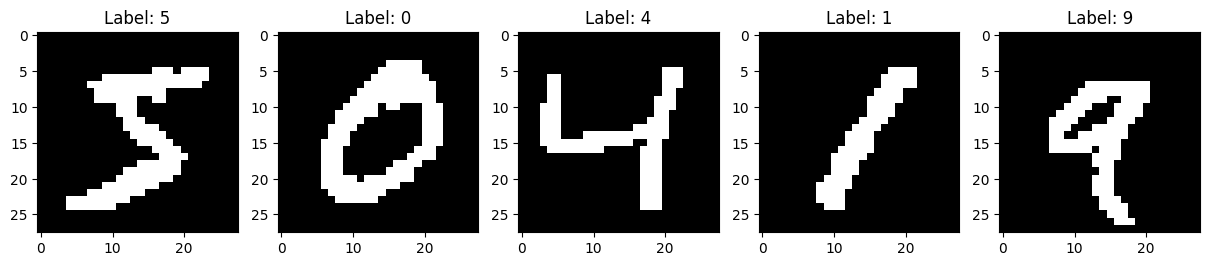

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    HopfieldActivation(),
])

subset_size = 50
dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=False)
dataset = torch.utils.data.Subset(dataset, range(subset_size))

positive_dataset = PreloadedDataset.from_dataset(dataset, None, device)
# negative_dataset = PreloadedDataset.from_dataset(dataset, MixSamples(dataset), device)
print(f'Loaded MNIST with {len(positive_dataset)} samples')

# show first samples positives
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(positive_dataset[i][0].cpu().numpy()), cmap='gray')
    axs[i].set_title(f"Label: {positive_dataset[i][1]}")
plt.show()

# show first samples negatives
# import matplotlib.pyplot as plt
# import numpy as np
# fig, axs = plt.subplots(1, 5, figsize=(15, 5))
# for i in range(5):
#     axs[i].imshow(np.squeeze(negative_dataset[i][0].numpy()), cmap='gray')
#     axs[i].set_title(f"Label: {negative_dataset[i][1]}")
# plt.show()

In [6]:
from tqdm import tqdm

def train(
    model,
    train_dataset,
    batch_size,
    p_energies,
    n_energies,
    epochs,
    steps,
    lr,
    wd,
):
    with torch.no_grad():
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        for epoch in range(epochs):
            epoch_p_energies = []
            epoch_n_energies = []
            loop = tqdm(train_loader, total=len(train_loader), leave=False)
            particles = [model.init_state(batch_size=batch_size) for _ in range(len(train_loader))]

            if epoch > 0 and len(p_energies) > 0:
                loop.set_description(f"Epoch {epoch+1}/{epochs} - p_Energy: {p_energies[-1]:.4f} - n_Energy: {n_energies[-1]:.4f}")

            for i, (x, _) in enumerate(loop):
                x = x.view(x.shape[0], -1)
                model.zero_grad()
                epoch_p_energies.append(model.learn(x, steps))
                particles[i], n_energy = model.unlearn(particles[i], int(steps/5))
                epoch_n_energies.append(n_energy)

                for p in model.parameters():
                    p.data += lr*(p.grad - wd*p.data)


            p_energies.append(sum(epoch_p_energies)/len(epoch_p_energies))
            n_energies.append(sum(epoch_n_energies)/len(epoch_n_energies))


        return p_energies, n_energies

In [24]:
model = BoltzmannMachine(784, 400, device)
p_energies = []
n_energies = []

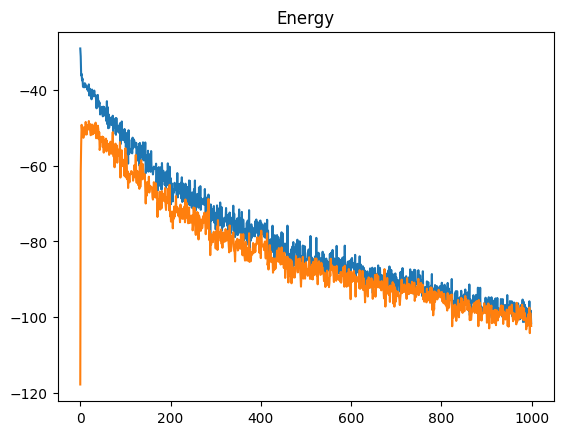

In [25]:
p_energies, n_energies = train(
    model,
    positive_dataset,
    50,
    p_energies,
    n_energies,
    epochs=1000,
    steps=100,
    lr=0.001,
    wd=0.001,
)

plt.plot(p_energies, label='Positive')
plt.plot(n_energies, label='Negative')
plt.title('Energy')
plt.show()

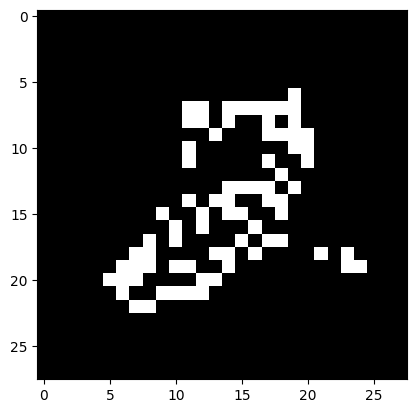

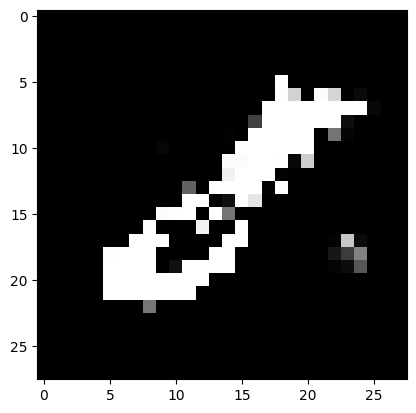

In [31]:
x = positive_dataset[torch.randint(0, len(positive_dataset), (1,))][0]
x = x * torch.bernoulli(torch.ones_like(x)*0.5)

# show x
plt.imshow(np.squeeze(x.cpu().numpy()), cmap='gray')
plt.show()

x = model.reconstruct(x.view(1, -1)).view(1, 28, 28)

# show x
plt.imshow(np.squeeze(x.cpu().detach().numpy()), cmap='gray')
plt.show()
